전처리의 시각화만 따로 만든 것입니다.

In [134]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re
from soynlp.normalizer import repeat_normalize
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from collections import Counter

#필요없는 경고무시
import warnings
warnings.filterwarnings('ignore')

#시각화용 임포트 모음
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go

In [135]:
#1. Naver Sentiment Movie Corpus v1.0 다운로드
train_file = tf.keras.utils.get_file('train.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')

#파일을 이진모드로 읽어온다. 디코드는 utf8로한다.
train_text = open(train_file,'rb').read().decode(encoding='utf-8')

#테스트용
# test_file = tf.keras.utils.get_file( 'test.txt','https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')
# test_text = open(test_file,'rb').read().decode(encoding='utf-8')


df_train = pd.DataFrame({
    'text':[ row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t')>0 ],
    'sentiment': [ int(row.split('\t')[2]) for row in train_text.split('\n')[1:] if row.count('\t')>0]
})

# 데이터 크기 지정
df_train = df_train[::5]

#널값있는지 확인
empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))

if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

#널값제거
#빈 문자열을 NaN 값으로 대체
df_train[{'text','sentiment'}].replace('', np.nan, inplace=True)

# NaN 값을 포함하는 행 제거
df_train.dropna( inplace=True)

print(df_train)


빈 문자열이 없습니다.
                                                 text  sentiment
0                                 아 더빙.. 진짜 짜증나네요 목소리          0
5       막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.          0
10                                   걍인피니트가짱이다.진짜짱이다♥          1
15                                   ㄱ냥 매번 긴장되고 재밋음ㅠㅠ          1
20          나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님          1
...                                               ...        ...
149975                               무지 자극적 에로틱 드라마!!          1
149980         아, 진짜 웃긴다...프랑스 영화 정말 싫어했었는데 이 영화는 열외~          1
149985                    해석하기 나름인 패륜영화. 그래도 이건 아니잖니.          0
149990                                   이걸 영화라고 찎었냐?          0
149995                            인간이 문제지.. 소는 뭔죄인가..          0

[30000 rows x 2 columns]


In [136]:
# train 데이터 입력값(X)을 정제(Cleaning)
def clean_korean_text(text):
    # 특수 문자 및 숫자 제거
    text = re.sub(r'[^가-힣ㄱ-ㅎㅏ-ㅣ\s]', ' ', text)
    # 반복되는 자음, 모음 제거 (e.g., 'ㅋㅋㅋ' -> 'ㅋ')
    text = repeat_normalize(text, num_repeats=1)
    # 띄어쓰기 정규화 (연속된 공백 문자를 하나의 공백 문자로 변환)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df_train['text']=df_train['text'].apply(lambda x:clean_korean_text(x))
df_train

,text,sentiment
0,아 더빙 진짜 짜증나네요 목소리,0
5,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화 ㅋㅋㅋ 별반개도 아까움,0
10,걍인피니트가짱이다 진짜짱이다,1
15,ㄱ냥 매번 긴장되고 재밋음ㅠㅠ,1
20,나름 심오한 뜻도 있는 듯 그냥 학생이 선생과 놀아나는 영화는 절대 아님,1
...,...,...
149975,무지 자극적 에로틱 드라마,1
149980,아 진짜 웃긴다 프랑스 영화 정말 싫어했었는데 이 영화는 열외,1
149985,해석하기 나름인 패륜영화 그래도 이건 아니잖니,0
149990,이걸 영화라고 찎었냐,0


In [137]:
#빈문자열 존재 확인
empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))

if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

빈 문자열이 존재합니다.


In [138]:
#빈문자열제거
df_train.drop(df_train[df_train['text'] == ""].index, inplace=True)

empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))
if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

빈 문자열이 없습니다.


,sentiment,text
1,positive,14905
0,negative,14869


<AxesSubplot:xlabel='sentiment', ylabel='count'>

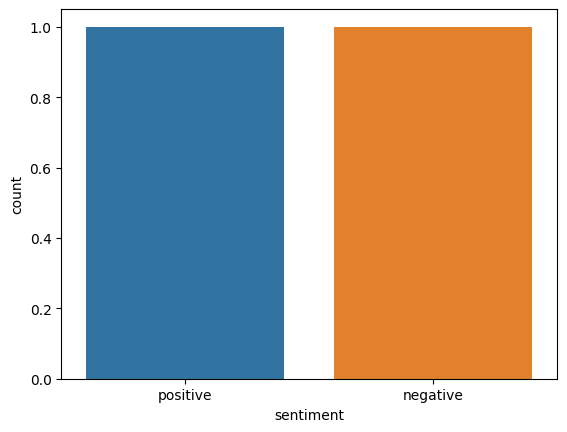

In [139]:
#긍정/부정 분포 시각화
temp = df_train.groupby('sentiment').count().reset_index().sort_values(by='text',ascending=False)
temp['sentiment']=temp['sentiment'].replace({0:'negative',1:'positive'})
display(temp)

# plt.figure(figsize=(12,6)) #크기조절
sns.countplot(x='sentiment',data=temp)

In [140]:
#정제된 텍스트를 mecab토큰화한다 ,여기서는 임시로 Okt
from konlpy.tag import Mecab
mecab=Mecab(dicpath=r'C:\mecab\mecab-ko-dic')
df_train['text']=df_train['text'].apply(lambda x: mecab.morphs(x))
df_train

,text,sentiment
0,"[아, 더, 빙, 진짜, 짜증, 나, 네요, 목소리]",0
5,"[막, 걸음마, 뗀, 세, 부터, 초등, 학교, 학년, 생, 인, 살용, 영화, ㅋ...",0
10,"[걍인피니트가짱이다, 진짜, 짱, 이, 다]",1
15,"[ㄱ, 냥, 매번, 긴장, 되, 고, 재, 밋, 음, ㅠㅠ]",1
20,"[나름, 심오, 한, 뜻, 도, 있, 는, 듯, 그냥, 학생, 이, 선생, 과, 놀...",1
...,...,...
149975,"[무지, 자극, 적, 에로, 틱, 드라마]",1
149980,"[아, 진짜, 웃긴다, 프랑스, 영화, 정말, 싫, 어, 했었, 는데, 이, 영화,...",1
149985,"[해석, 하, 기, 나름, 인, 패, 륜, 영화, 그래도, 이건, 아니, 잖니]",0
149990,"[이걸, 영화, 라고, 찎었냐]",0


In [141]:
# 긍정/부정 공통으로 단어의 등장 빈도 수 순위
bindo = Counter([token for text in df_train['text'] for token in text])
df_count = pd.DataFrame.from_dict(bindo, orient='index', columns=['count']).sort_values('count', ascending=False)

#상위20 토큰만 출력
df_count.reset_index(inplace=True)
df_count.rename(columns={'index':'word'},inplace=True)
df_count[:20].style.background_gradient(cmap='Purples')

,word,count
0,이,14563
1,는,13367
2,영화,11441
3,다,11070
4,고,9451
5,하,8944
6,도,6848
7,의,6584
8,가,6577
9,은,6264


In [142]:
#불용어 사전불러오기
stopwords = open('./stopwords.txt','rb').read().decode(encoding='utf-8').split('\r\n')
stopwords

['가',
 '가까스로',
 '가령',
 '각',
 '각각',
 '각자',
 '각종',
 '갖고말하자면',
 '같다',
 '같이',
 '개의치않고',
 '거니와',
 '거바',
 '거의',
 '것',
 '것과 같이',
 '것들',
 '게다가',
 '게우다',
 '겨우',
 '견지에서',
 '결과에 이르다',
 '결국',
 '결론을 낼 수 있다',
 '겸사겸사',
 '고려하면',
 '고로',
 '곧',
 '공동으로',
 '과',
 '과연',
 '관계가 있다',
 '관계없이',
 '관련이 있다',
 '관하여',
 '관한',
 '관해서는',
 '구',
 '구체적으로',
 '구토하다',
 '그',
 '그들',
 '그때',
 '그래',
 '그래도',
 '그래서',
 '그러나',
 '그러니',
 '그러니까',
 '그러면',
 '그러므로',
 '그러한즉',
 '그런 까닭에',
 '그런데',
 '그런즉',
 '그럼',
 '그럼에도 불구하고',
 '그렇게 함으로써',
 '그렇지',
 '그렇지 않다면',
 '그렇지 않으면',
 '그렇지만',
 '그렇지않으면',
 '그리고',
 '그리하여',
 '그만이다',
 '그에 따르는',
 '그위에',
 '그저',
 '그중에서',
 '그치지 않다',
 '근거로',
 '근거하여',
 '기대여',
 '기점으로',
 '기준으로',
 '기타',
 '까닭으로',
 '까악',
 '까지',
 '까지 미치다',
 '까지도',
 '꽈당',
 '끙끙',
 '끼익',
 '나',
 '나머지는',
 '남들',
 '남짓',
 '너',
 '너희',
 '너희들',
 '네',
 '넷',
 '년',
 '논하지 않다',
 '놀라다',
 '누가 알겠는가',
 '누구',
 '다른',
 '다른 방면으로',
 '다만',
 '다섯',
 '다소',
 '다수',
 '다시 말하자면',
 '다시말하면',
 '다음',
 '다음에',
 '다음으로',
 '단지',
 '답다',
 '당신',
 '당장',
 '대로 하다',
 '대하면',
 '대하여',
 '대해 말하자면',
 '대해서',
 '댕그',


In [143]:
#불용어 제거 적용
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([word for word in x if word not in stopwords]).split() )
df_train

,text,sentiment
0,"[더, 빙, 진짜, 짜증, 네요, 목소리]",0
5,"[막, 걸음마, 뗀, 세, 초등, 학교, 학년, 생, 인, 살용, ㅋㅋㅋ, 별반, ...",0
10,"[걍인피니트가짱이다, 진짜, 짱]",1
15,"[ㄱ, 냥, 긴장, 되, 재, 밋, 음, ㅠㅠ]",1
20,"[나름, 심오, 한, 뜻, 있, 듯, 그냥, 학생, 선생, 놀아나, 절대, 아님]",1
...,...,...
149975,"[무지, 자극, 적, 에로, 틱, 드라마]",1
149980,"[진짜, 웃긴다, 프랑스, 정말, 싫, 했었, 는데, 열외]",1
149985,"[해석, 기, 나름, 인, 패, 륜, 이건, 잖니]",0
149990,"[이걸, 라고, 찎었냐]",0


In [145]:
#불용어 제거후 긍정/부정 공통으로 단어의 등장 빈도 수 순위
bindo = Counter([token for text in df_train['text'] for token in text])
df_count = pd.DataFrame.from_dict(bindo, orient='index', columns=['count']).sort_values('count', ascending=False)

#상위20 토큰만 출력
df_count.reset_index(inplace=True)
df_count.rename(columns={'index':'word'},inplace=True)
df_count[:20].style.background_gradient(cmap='Blues')

,word,count
0,보,5131
1,한,5101
2,게,4334
3,지,3792
4,있,3385
5,없,3098
6,좋,2809
7,었,2456
8,만,2345
9,는데,2248


In [146]:
#토큰화된걸 ' ' 공백한칸을 기준으로 다시 합쳐준다.
df_train['text']=df_train['text'].apply(lambda x: ' '.join(i for i in x) )
df_train
#==> 교착어의 단점을 보완해준것이다.

,text,sentiment
0,더 빙 진짜 짜증 네요 목소리,0
5,막 걸음마 뗀 세 초등 학교 학년 생 인 살용 ㅋㅋㅋ 별반 개 아까움,0
10,걍인피니트가짱이다 진짜 짱,1
15,ㄱ 냥 긴장 되 재 밋 음 ㅠㅠ,1
20,나름 심오 한 뜻 있 듯 그냥 학생 선생 놀아나 절대 아님,1
...,...,...
149975,무지 자극 적 에로 틱 드라마,1
149980,진짜 웃긴다 프랑스 정말 싫 했었 는데 열외,1
149985,해석 기 나름 인 패 륜 이건 잖니,0
149990,이걸 라고 찎었냐,0


In [147]:
df_train['text'].str.len().quantile(0.9)

62.70000000000073

리뷰의 최대 길이 : 200
리뷰의 평균 길이 : 29.009706455296566
리뷰의 90%를 포함하는 길이 : 62.70000000000073


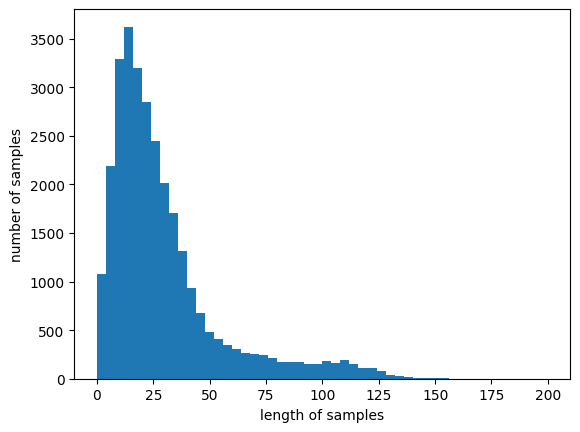

In [148]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in df_train['text']))
print('리뷰의 평균 길이 :',sum(map(len, df_train['text']))/len(df_train['text']))
print('리뷰의 90%를 포함하는 길이 :', df_train['text'].str.len().quantile(0.9) )
plt.hist([len(review) for review in df_train['text']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 리뷰의 90%를 포함하는 길이
max_length = df_train['text'].str.len().quantile(0.9)

#너무 긴 리뷰와 길이1 문자열을 삭제
df_train = df_train[(df_train['text'].str.len() >= 2) & (df_train['text'].str.len() <= max_length)]

In [76]:
#리뷰의 총개수
print(df_train['text'].count())
print(df_train['sentiment'].count())

26600
26600


In [77]:
#tfidf 벡터화 적용
vectorizer=TfidfVectorizer( )
x = vectorizer.fit_transform(df_train['text'])
y = df_train['sentiment']

# vectorizer 객체를 저장 => 입력되는 문자도 똑같이 벡터화해줌
# with open('test2_nofunc_vectorizer.pkl', 'wb') as f:
#     pickle.dump(vectorizer, f)


#희소행렬을 밀집행렬로 바꾸어준다. 문제점: 차원이 너무 커져서 많은 데이터를 학습시킬수없다.
x_train_dense = np.expand_dims( x.toarray(), axis=-1 )

In [82]:
#DNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization , Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    # input_layer,
    Input(shape=(x_train_dense.shape[1],)),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일 및 학습
optimizer= Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 콜백 정의
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# model.fit(X.toarray(), y, epochs = 10, batch_size = 500, validation_split=0.2)  #0.8417
model.fit(
    x.toarray(), y, 
    epochs = 30, batch_size = 300, 
    validation_split=0.3,
    callbacks=[early_stopping]
    ) 

Epoch 1/30
63/63 [==============================] - 9s 93ms/step - loss: 0.8809 - accuracy: 0.5600 - val_loss: 0.6912 - val_accuracy: 0.4957
Epoch 2/30
63/63 [==============================] - 4s 61ms/step - loss: 0.6642 - accuracy: 0.6671 - val_loss: 0.6857 - val_accuracy: 0.4962
Epoch 3/30
63/63 [==============================] - 3s 49ms/step - loss: 0.5347 - accuracy: 0.7421 - val_loss: 0.6741 - val_accuracy: 0.5139
Epoch 4/30
63/63 [==============================] - 3s 51ms/step - loss: 0.4537 - accuracy: 0.7904 - val_loss: 0.6589 - val_accuracy: 0.5343
Epoch 5/30
63/63 [==============================] - 3s 47ms/step - loss: 0.3805 - accuracy: 0.8328 - val_loss: 0.6332 - val_accuracy: 0.5825
Epoch 6/30
63/63 [==============================] - 3s 51ms/step - loss: 0.3267 - accuracy: 0.8606 - val_loss: 0.5992 - val_accuracy: 0.6455
Epoch 7/30
63/63 [==============================] - 3s 48ms/step - loss: 0.2908 - accuracy: 0.8800 - val_loss: 0.5639 - val_accuracy: 0.6956
Epoch 8/30
63